In [65]:
import torch #Main PyTorch library for tensor computation and GPU support
import torch.nn as nn # Provides neural network layers and building blocks
import torch.nn.functional as F #Provides neural network layers and building blocks
import torch.optim as optim #Provides optimization algorithms like SGD, Adam, etc.
from torch.utils.data import DataLoader #Utility to batch, shuffle, and load data in parallel.
import torchvision #Popular computer vision library with datasets and models.
import torchvision.transforms as transforms #Used for preprocessing like normalization or converting images to tensors.
from torchsummary import summary
# !pip install torchviz
from torchviz import make_dot
from IPython.display import Image
# !pip install graphviz
from graphviz import Digraph


import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import warnings
warnings.filterwarnings('ignore')
import random


# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [66]:
# =====================================
# 1. IMPORT EVERYTHING & DATA SETUP
# =====================================

# Data augmentation and normalization

# transform_train = transforms.Compose([
#     transforms.RandomCrop(32, padding=4),
#     transforms.RandomHorizontalFlip(p=0.5),
#     transforms.RandomRotation(degrees=15),  # Increased rotation range
#     transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.15),  # More aggressive color jittering
#     transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Random translation
#     transforms.RandomGrayscale(p=0.1),  # Occasionally convert to grayscale
#     transforms.ToTensor(),
#     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),  # CIFAR-10 specific normalization
#     transforms.RandomErasing(p=0.3, scale=(0.02, 0.25), ratio=(0.3, 3.3)),  # Cutout/Random erasing (applied after ToTensor)
# ])

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=20),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.15, 0.15), scale=(0.9, 1.1), shear=10),
    transforms.RandomGrayscale(p=0.15),
    transforms.RandomApply([transforms.RandomPerspective(distortion_scale=0.2, p=1.0)], p=0.3),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    transforms.RandomErasing(p=0.4, scale=(0.02, 0.33), ratio=(0.3, 3.3)),  # Applied after ToTensor
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=2)


In [67]:

# =====================================
# 2. NEURAL NETWORK MODEL
# =====================================

import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

def get_resnet18():
    model = models.resnet18(pretrained=True)
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    model.maxpool = nn.Identity()
    model.fc = nn.Linear(512, 10)
    return model


# Replace CIFAR10BigNet with this:
model = get_resnet18().to(device)
print(model)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): Identity()
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), p

In [68]:
# =====================================
# 3. QUANTIZATION FUNCTIONS
# =====================================

def quantize_weights_int8(weights):
    """
    Quantize weights to 8-bit integers (1 byte per weight)
    input take weight which are float32

    """
    # Find min and max values
    w_min = weights.min()
    w_max = weights.max()

    # Calculate scale and zero point
    scale = (w_max - w_min) / 255.0
    zero_point = torch.round(-w_min / scale).clamp(0, 255) #ensures that the mapping preserves the original values.

    # Quantize
    quantized = torch.round(weights / scale + zero_point).clamp(0, 255)

    # Store quantization parameters
    return quantized.to(torch.uint8), scale, zero_point

def dequantize_weights_int8(quantized_weights, scale, zero_point):
    """
    Convert quantized weights back to float32
    """
    return scale * (quantized_weights.float() - zero_point)

def quantize_model_weights(model):
    """Fixed quantization function that properly handles all parameters"""
    from copy import deepcopy
    quantized_model = deepcopy(model).to(device)
    quant_params = {}

    with torch.no_grad():
        for name, param in quantized_model.named_parameters():
            if param.requires_grad:  # Only quantize trainable parameters
                data = param.data
                max_abs = torch.max(torch.abs(data)).item()
                scale = max_abs / 127.0 if max_abs > 0 else 1.0

                quant_params[name] = scale
                quantized = torch.round(data / scale).clamp(-128, 127).to(torch.int8)

                # 🔥 Ensure _quantized is attached to ALL parameters
                param._quantized = quantized.clone()

                # Set dequantized weights back
                param.data.copy_(quantized.to(torch.float32) * scale)
                
                print(f"[DEBUG] Quantized {name}: shape={param.shape}, scale={scale:.6f}")

    return quantized_model, quant_params


In [69]:
# =====================================
# 4. TRAINING FUNCTION
# =====================================


def train_model(model, train_loader, test_loader=None, epochs=20, lr=0.001):
    """
    Improved training function - mid complexity
    
    Key improvements over original:
    - Better optimizer (AdamW)
    - Learning rate scheduler
    - Validation during training
    - Track training accuracy
    - Simple early stopping
    """
    
    # Better optimizer with weight decay
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
    
    # Learning rate scheduler - reduces LR when loss plateaus
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5)
    
    # Early stopping
    best_val_acc = 0
    patience_counter = 0
    patience = 7
    
    print(f"Training for up to {epochs} epochs...")
    print("-" * 60)
    
    for epoch in range(epochs):
        # ===================
        # TRAINING PHASE
        # ===================
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            output = model(data)
            loss = F.cross_entropy(output, target)
            loss.backward()
            optimizer.step()
            
            # Track metrics
            train_loss += loss.item()
            pred = output.argmax(dim=1)
            train_correct += pred.eq(target).sum().item()
            train_total += target.size(0)
            
            # Progress update
            if batch_idx % 100 == 0:
                print(f'Epoch {epoch+1}/{epochs}, Batch {batch_idx}, Loss: {loss.item():.4f}')
        
        # Calculate training metrics
        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = 100.0 * train_correct / train_total
        
        # ===================
        # VALIDATION PHASE
        # ===================
        val_accuracy = 0
        val_loss = avg_train_loss  # fallback to train loss
        
        if test_loader is not None:
            model.eval()
            val_loss = 0
            val_correct = 0
            val_total = 0
            
            with torch.no_grad():
                for data, target in test_loader:
                    data, target = data.to(device), target.to(device)
                    output = model(data)
                    val_loss += F.cross_entropy(output, target).item()
                    pred = output.argmax(dim=1)
                    val_correct += pred.eq(target).sum().item()
                    val_total += target.size(0)
            
            val_loss = val_loss / len(test_loader)
            val_accuracy = 100.0 * val_correct / val_total
        
        # Update learning rate based on validation loss
        scheduler.step(val_loss)
        
        # ===================
        # EARLY STOPPING
        # ===================
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            patience_counter = 0
            # Save best model
            torch.save(model.state_dict(), 'best_model.pth')
            best_marker = " ⭐ (best)"
        else:
            patience_counter += 1
            best_marker = ""
        
        # Print epoch results
        if test_loader is not None:
            print(f'Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}% | '
                  f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%{best_marker}')
        else:
            print(f'Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%{best_marker}')
        
        # # Early stopping check
        # if patience_counter >= patience:
        #     print(f'\nEarly stopping at epoch {epoch+1}! Best validation accuracy: {best_val_acc:.2f}%')
        #     break
    
    # Load best model if we saved one
    if test_loader is not None and best_val_acc > 0:
        model.load_state_dict(torch.load('best_model.pth'))
        print(f"Loaded best model with validation accuracy: {best_val_acc:.2f}%")
    
    print("-" * 60)
    print("Training completed!")
    
    return best_val_acc if test_loader is not None else train_accuracy



In [70]:
# =====================================
# 5. TEST BENCH FUNCTION
# =====================================

def test_model(model, test_loader, model_name="Model"):
    """Test the model and return accuracy"""
    model.eval() #Disables layers like dropout and batch norm from updating.
    #Ensures consistent behavior during testing.
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad(): #Prevents PyTorch from computing gradients
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            # Computes total negative log-likelihood loss over the batch (using sum for aggregation).
            # Accumulates the total test loss across all batches.
            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)

    test_loss /= total
    accuracy = 100. * correct / total

    print(f'{model_name} - Test Loss: {test_loss:.4f}, Accuracy: {correct}/{total} ({accuracy:.2f}%)')
    return accuracy, test_loss

In [71]:
# =====================================
# 6. ANALYSIS AND PLOTTING FUNCTIONS
# =====================================

def analyze_weight_distribution(model, title="Weight Distribution"):
    """Analyze and plot weight distributions"""
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle(title)

    layer_idx = 0
    for name, param in model.named_parameters():
        if 'weight' in name and layer_idx < 4:
            weights = param.data.cpu().numpy().flatten()
            ax = axes[layer_idx // 2, layer_idx % 2]
            ax.hist(weights, bins=50, alpha=0.7)
            ax.set_title(f'{name}')
            ax.set_xlabel('Weight Value')
            ax.set_ylabel('Frequency')
            layer_idx += 1

    plt.tight_layout()
    plt.show()

def plot_accuracy_comparison(results):
    """Plot accuracy comparison"""
    models = list(results.keys())
    accuracies = [results[model]['accuracy'] for model in models]

    plt.figure(figsize=(10, 6))
    bars = plt.bar(models, accuracies, color=['blue', 'orange', 'green', 'red'][:len(models)])
    plt.ylabel('Accuracy (%)')
    plt.title('Model Accuracy Comparison')
    plt.ylim(0, 100)

    # Add value labels on bars
    for bar, acc in zip(bars, accuracies):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f'{acc:.2f}%', ha='center', va='bottom')

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def calculate_memory_usage(model, quantized_params=None):
    """Calculate memory usage of the model"""
    total_params = 0
    fp32_size = 0
    int8_size = 0

    for name, param in model.named_parameters():
        param_count = param.numel()
        total_params += param_count
        fp32_size += param_count * 4  # 4 bytes per float32

        if quantized_params and name in quantized_params:
            int8_size += param_count * 1  # 1 byte per int8
        else:
            int8_size += param_count * 4  # Keep as float32 if not quantized

    print(f"Total parameters: {total_params:,}")
    print(f"FP32 model size: {fp32_size / 1024:.2f} KB")
    print(f"INT8 model size: {int8_size / 1024:.2f} KB")
    print(f"Compression ratio: {fp32_size / int8_size:.2f}x")

    return total_params, fp32_size, int8_size


CIFAR-10 8-bit Weight Quantization Analysis

1. Training Original Model...
Training for up to 40 epochs...
------------------------------------------------------------
Epoch 1/40, Batch 0, Loss: 2.5727
Epoch 1/40, Batch 100, Loss: 1.5013
Epoch 1/40, Batch 200, Loss: 1.2107
Epoch 1/40, Batch 300, Loss: 1.4688
Epoch 1: Train Loss: 1.4952, Train Acc: 46.49%
Epoch 2/40, Batch 0, Loss: 1.2524
Epoch 2/40, Batch 100, Loss: 1.0857
Epoch 2/40, Batch 200, Loss: 1.0177
Epoch 2/40, Batch 300, Loss: 1.0919
Epoch 2: Train Loss: 1.1279, Train Acc: 60.31%
Epoch 3/40, Batch 0, Loss: 1.2807
Epoch 3/40, Batch 100, Loss: 0.8887
Epoch 3/40, Batch 200, Loss: 1.0162
Epoch 3/40, Batch 300, Loss: 0.8449
Epoch 3: Train Loss: 0.9996, Train Acc: 65.24%
Epoch 4/40, Batch 0, Loss: 0.9741
Epoch 4/40, Batch 100, Loss: 0.9849
Epoch 4/40, Batch 200, Loss: 0.9463
Epoch 4/40, Batch 300, Loss: 1.0107
Epoch 4: Train Loss: 0.9095, Train Acc: 68.27%
Epoch 5/40, Batch 0, Loss: 0.9024
Epoch 5/40, Batch 100, Loss: 0.8600
Epoch 

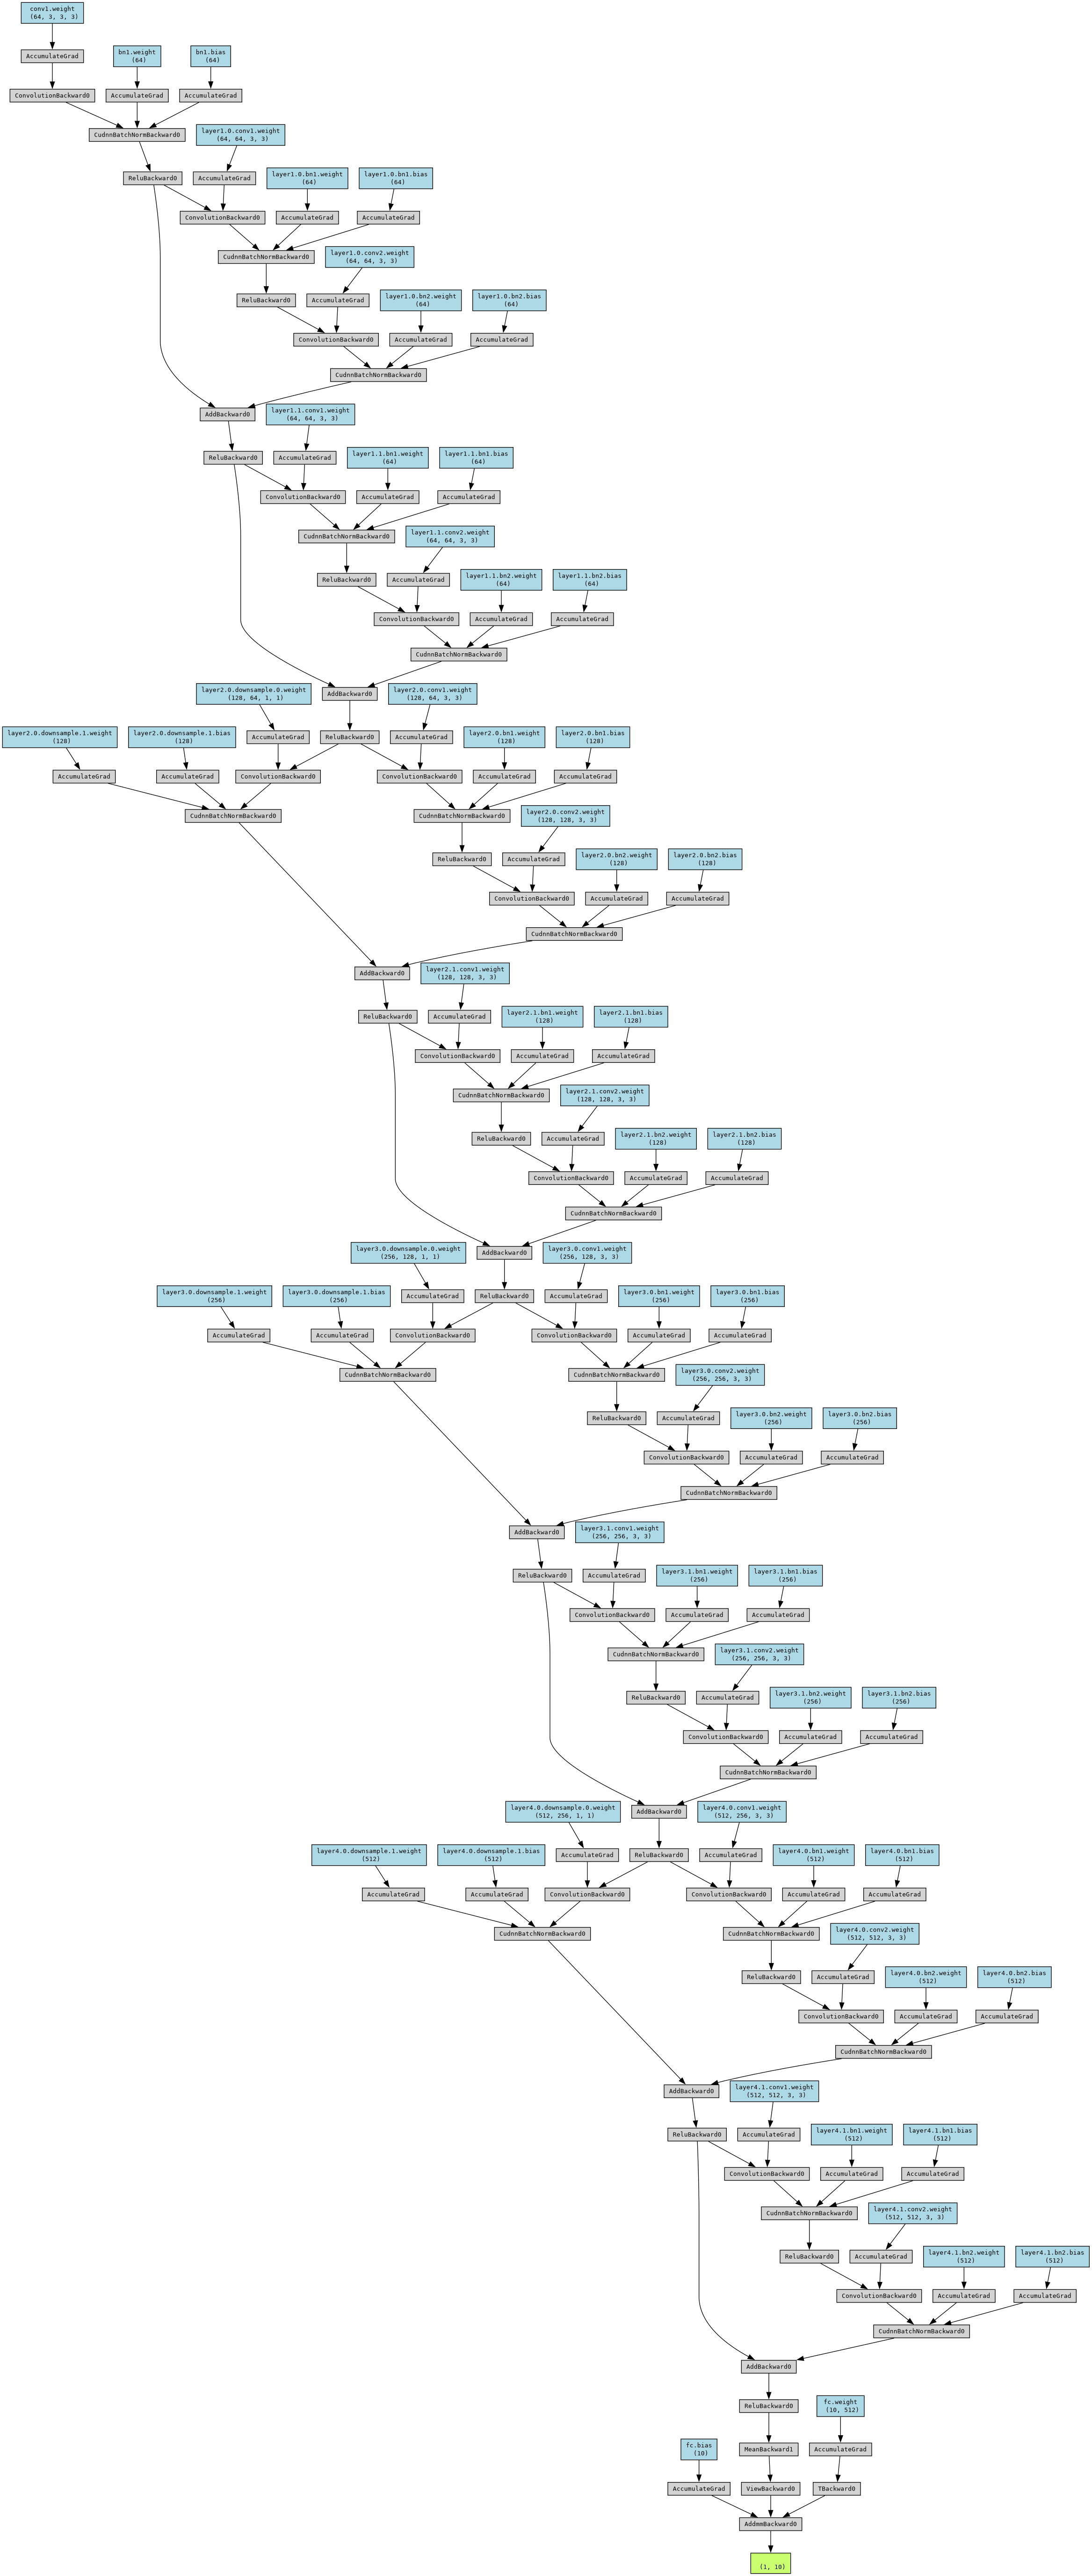


2. Testing Original Model...
Original FP32 - Test Loss: 0.4174, Accuracy: 8712/10000 (87.12%)

3. Quantizing Model Weights to 8-bit...
[DEBUG] Quantized conv1.weight: shape=torch.Size([64, 3, 3, 3]), scale=0.005025
[DEBUG] Quantized bn1.weight: shape=torch.Size([64]), scale=0.005006
[DEBUG] Quantized bn1.bias: shape=torch.Size([64]), scale=0.005781
[DEBUG] Quantized layer1.0.conv1.weight: shape=torch.Size([64, 64, 3, 3]), scale=0.007824
[DEBUG] Quantized layer1.0.bn1.weight: shape=torch.Size([64]), scale=0.004520
[DEBUG] Quantized layer1.0.bn1.bias: shape=torch.Size([64]), scale=0.004468
[DEBUG] Quantized layer1.0.conv2.weight: shape=torch.Size([64, 64, 3, 3]), scale=0.007035
[DEBUG] Quantized layer1.0.bn2.weight: shape=torch.Size([64]), scale=0.005895
[DEBUG] Quantized layer1.0.bn2.bias: shape=torch.Size([64]), scale=0.003571
[DEBUG] Quantized layer1.1.conv1.weight: shape=torch.Size([64, 64, 3, 3]), scale=0.005969
[DEBUG] Quantized layer1.1.bn1.weight: shape=torch.Size([64]), scale=0

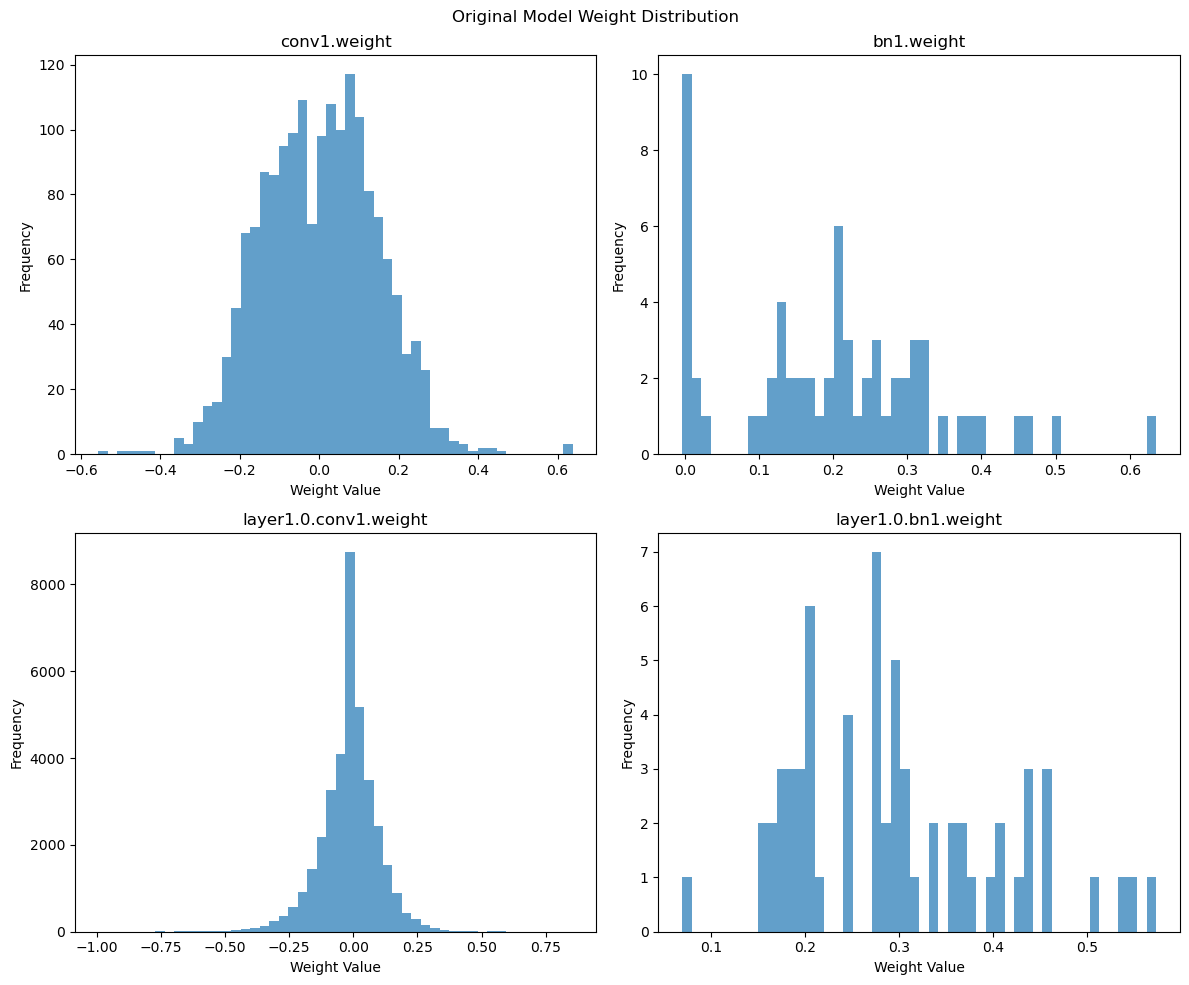

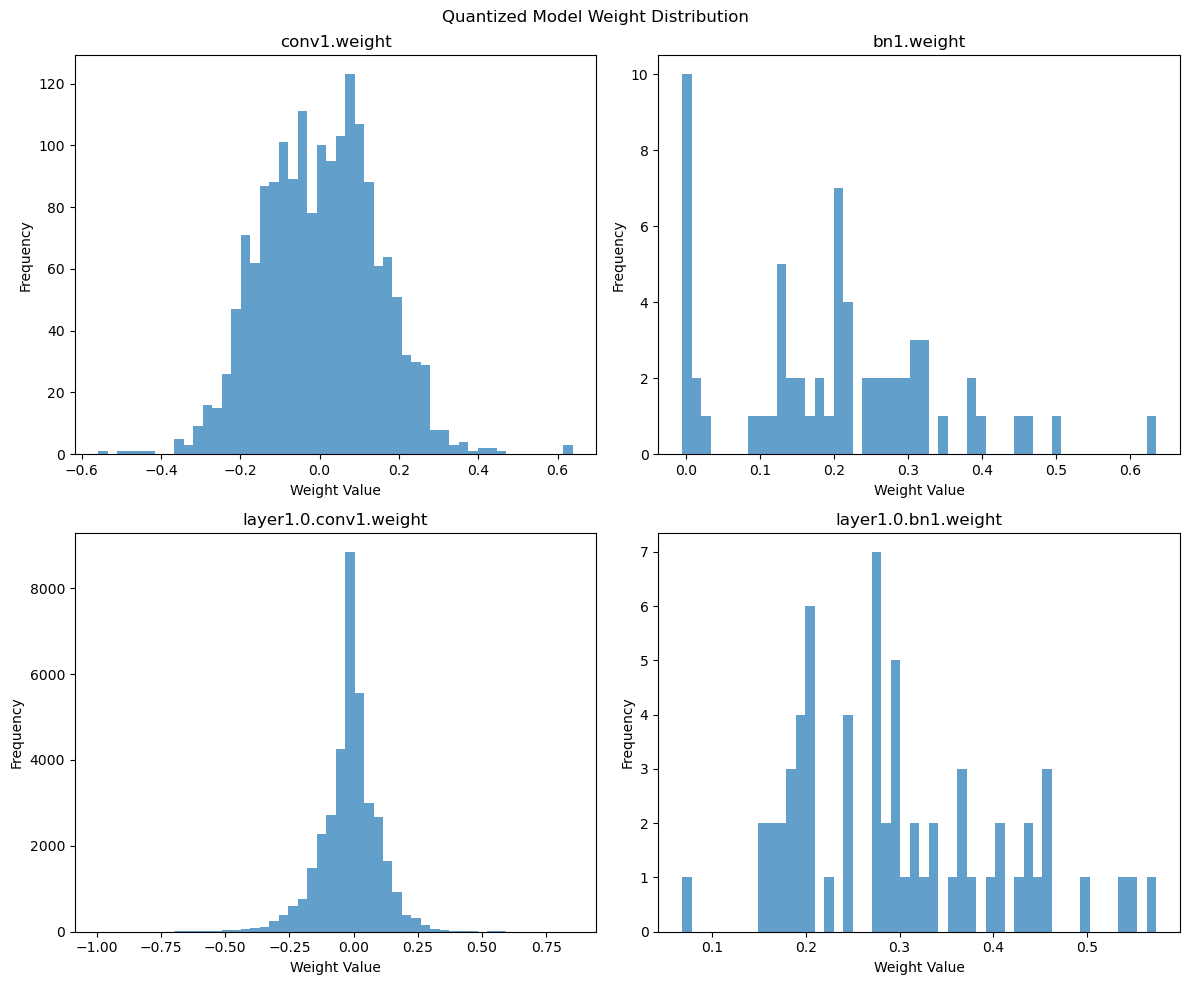

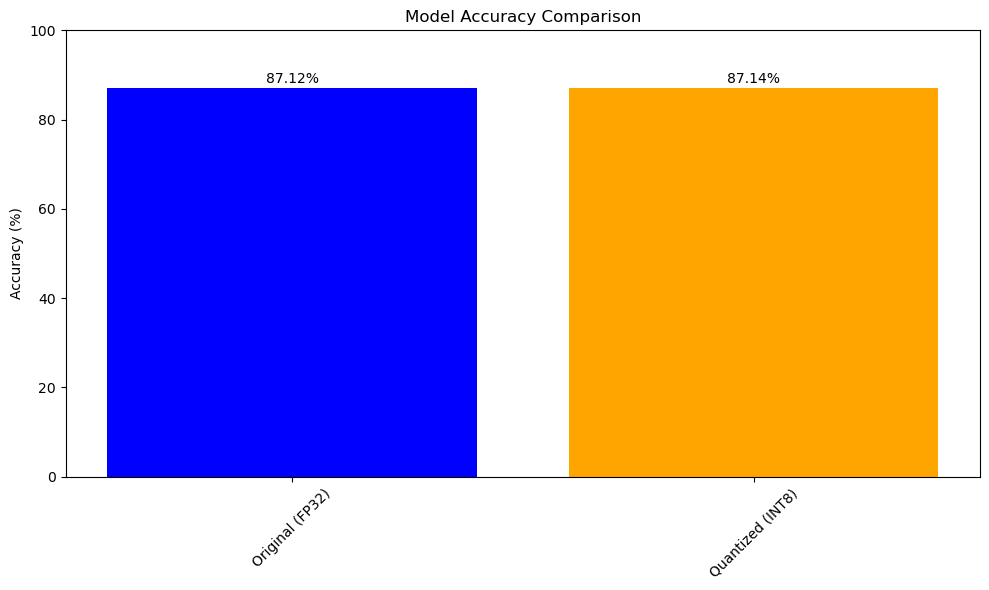


SETUP COMPLETE!
Ready for weight modifications!
Use the following functions to modify weights:
- modify_weights_percentage(model, percentage, layer_name)
- modify_specific_weights(model, weight_indices, new_values, layer_name)
- test_model(modified_model, test_loader, 'Modified Model')
- plot_accuracy_comparison(results)


In [ ]:
# =====================================
# 7. MAIN EXECUTION REGULAR PIPELINE
# =====================================

def main():
    print("=" * 60)
    print("CIFAR-10 8-bit Weight Quantization Analysis")
    print("=" * 60)

    # Initialize and train the original model
    print("\n1. Training Original Model...")
    original_model = get_resnet18().to(device)
    train_model(original_model, train_loader, epochs=50)

    # Create model and display summary
    from torchsummary import summary
    summary(original_model, input_size=(3, 32, 32))  # CIFAR-10 input is 3x32x32

    x = torch.randn(1, 3, 32, 32).to(device)  # Simulated CIFAR-10 input
    y = original_model(x)

    from torchviz import make_dot
    from IPython.display import Image
    make_dot(y, params=dict(original_model.named_parameters())).render("cifar10_net", format="png")
    display(Image(filename="cifar10_net.png"))  # ✅ show in notebook

    # Test original model
    print("\n2. Testing Original Model...")
    original_accuracy, original_loss = test_model(original_model, test_loader, "Original FP32")

    # Quantize model weights
    print("\n3. Quantizing Model Weights to 8-bit...")
    quantized_model, quant_params = quantize_model_weights(original_model)
    quantized_accuracy, quantized_loss = test_model(quantized_model, test_loader, "Quantized INT8")

    # Calculate memory usage
    print("\n4. Memory Usage Analysis...")
    calculate_memory_usage(original_model, quant_params)

    # Store results for comparison
    results = {
        'Original (FP32)': {'accuracy': original_accuracy, 'loss': original_loss},
        'Quantized (INT8)': {'accuracy': quantized_accuracy, 'loss': quantized_loss}
    }

    # Analyze weight distributions
    print("\n5. Analyzing Weight Distributions...")
    analyze_weight_distribution(original_model, "Original Model Weight Distribution")
    analyze_weight_distribution(quantized_model, "Quantized Model Weight Distribution")

    # Plot initial comparison
    plot_accuracy_comparison(results)

    print("\n" + "=" * 60)
    print("SETUP COMPLETE!")
    print("=" * 60)
    print("Ready for weight modifications!")
    print("Use the following functions to modify weights:")
    print("- modify_weights_percentage(model, percentage, layer_name)")
    print("- modify_specific_weights(model, weight_indices, new_values, layer_name)")
    print("- test_model(modified_model, test_loader, 'Modified Model')")
    print("- plot_accuracy_comparison(results)")

    return original_model, quantized_model, quant_params, results

# Run the main pipeline
if __name__ == "__main__":
    original_model, quantized_model, quant_params, results = main()

GroundTruth: cat ship ship airplane frog frog automobile frog cat automobile
Predicted:   cat ship ship ship frog frog automobile frog cat automobile


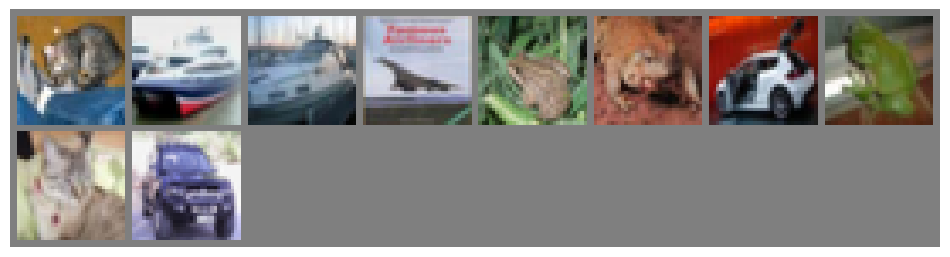

In [73]:
import matplotlib.pyplot as plt
import numpy as np

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

def visualize_predictions(model, test_loader):
    """Show 10 test images with predicted labels"""
    model.eval()
    data_iter = iter(test_loader)
    images, labels = next(data_iter)
    images, labels = images.to(device), labels.to(device)

    outputs = model(images[:10])
    _, predicted = torch.max(outputs, 1)

    plt.figure(figsize=(12, 4))
    imshow(torchvision.utils.make_grid(images[:10].cpu()))
    print('GroundTruth:', ' '.join(f'{classes[labels[j]]}' for j in range(10)))
    print('Predicted:  ', ' '.join(f'{classes[predicted[j]]}' for j in range(10)))


visualize_predictions(original_model, test_loader)



In [74]:
def get_mask_for_fast_read(j_upper: int, j_lower: int) -> int:
    """
    Return an 8-bit mask preserving the top j_upper bits in the upper nibble
    and top j_lower bits in the lower nibble, counting MSBs from left to right.
    """
    assert 0 <= j_upper <= 4
    assert 0 <= j_lower <= 4

    def nibble_mask(j: int) -> int:
        return ((1 << j) - 1) << (4 - j) if j > 0 else 0

    upper_mask = nibble_mask(j_upper) << 4  # Correct: shift to bits 7–4
    lower_mask = nibble_mask(j_lower)       # Correct: stays in bits 3–0

    return upper_mask | lower_mask

In [75]:
def simulate_fast_read_from_mem_regular(array: np.ndarray, j_upper: int, j_lower: int) -> np.ndarray:
    """
    Simulate fast memory read by applying a nibble-wise MSB mask to the input array.
    Returns a masked array.
    """
    assert array.dtype == np.int8, "Input array must be int8"
    assert 0 <= j_upper <= 4, "j_upper must be in [0, 4]"
    assert 0 <= j_lower <= 4, "j_lower must be in [0, 4]"

    mask = get_mask_for_fast_read(j_upper, j_lower)

    # Perform bitwise AND using unsigned interpretation
    unsigned_vals = array.astype(np.uint8)
    masked_vals = unsigned_vals & mask

    return masked_vals.astype(np.int8)


def simulate_fast_read_from_mem_median(array: np.ndarray, j_upper: int, j_lower: int) -> np.ndarray:
    """
    Same as simulate_fast_read_from_mem_regular but also sets the first bit 
    *after* the j_upper MSBs (in upper nibble), or if j_upper==4, the first 
    bit after j_lower (in lower nibble).
    """
    assert array.dtype == np.int8, "Input array must be int8"
    assert 0 <= j_upper <= 4
    assert 0 <= j_lower <= 4

    base_mask = get_mask_for_fast_read(j_upper, j_lower)
    extra_bit = 0

    if j_upper < 4:
        # Set first zero bit after upper MSBs: upper nibble bits are at positions 7–4
        extra_bit = 1 << (7 - j_upper)
    elif j_lower < 4:
        # Set first zero bit after lower MSBs: bits 3–0
        extra_bit = 1 << (3 - j_lower)
    # else: j_upper == 4 and j_lower == 4 → no extra bit

    # Perform bitwise AND using unsigned interpretation
    unsigned_vals = array.astype(np.uint8)
    masked_vals = unsigned_vals & base_mask
    out = masked_vals | extra_bit

    return out.astype(np.int8)



def simulate_fast_read_from_mem_median_double(array: np.ndarray, j_upper: int, j_lower: int) -> np.ndarray:
    """
    Sets one bit after the upper MSBs and one bit after the lower MSBs (if not full).
    """
    assert array.dtype == np.int8, "Input array must be int8"
    assert 0 <= j_upper <= 4
    assert 0 <= j_lower <= 4

    base_mask = get_mask_for_fast_read(j_upper, j_lower)
    extra_bit1 = 0
    extra_bit2 = 0

    if j_upper < 4:
        extra_bit1 = 1 << (7 - j_upper)
    if j_lower < 4:
        extra_bit2 = 1 << (3 - j_lower)

    unsigned_vals = array.astype(np.uint8)
    masked_vals = unsigned_vals & base_mask
    out = masked_vals | extra_bit1 | extra_bit2

    return out.view(np.int8)  # ✅ fixed



In [76]:
def make_halfbyte_msb_function(alg: str):
    """
    Returns a function(array: np.ndarray, j: int) -> np.ndarray that applies
    either simulate_fast_read_from_mem_regular or simulate_fast_read_from_mem_median
    to the 4-bit inputs.
    """
    if alg == "regular":
        def fn(array: np.ndarray,  j_upper: int, j_lower: int) -> np.ndarray:
            return simulate_fast_read_from_mem_regular(array, j_upper, j_lower)  # j_upper=j, j_lower=0
        return fn
    elif alg == "median":
        def fn(array: np.ndarray,  j_upper: int, j_lower: int) -> np.ndarray:
            return simulate_fast_read_from_mem_median(array,  j_upper, j_lower)
        return fn
    elif alg == "double_median":
        def fn(array: np.ndarray,  j_upper: int, j_lower: int) -> np.ndarray:
            return simulate_fast_read_from_mem_median_double(array,  j_upper, j_lower)
        return fn
    else:
        raise ValueError(f"Unknown strategy: {alg}")


In [77]:
import numpy as np
import torch
from copy import deepcopy

def apply_half_msb_perturbation(original_model, quant_params, j_upper, j_lower, msb_function):
    """
    Apply MSB perturbation to quantized weights using a mask defined by (j_upper, j_lower).
    """
    # Clone model
    perturbed_model = deepcopy(original_model).to(next(original_model.parameters()).device)
    total_changed = 0
    total_weights = 0

    with torch.no_grad():
        for name, param in perturbed_model.named_parameters():
            if name not in quant_params:
                continue

            # Get quantization parameters
            if isinstance(quant_params[name], dict):
                # If quant_params stores scale and zero_point
                scale = quant_params[name]['scale']
                zero_point = quant_params[name].get('zero_point', 0)
                
                # Quantize current weights to int8
                quantized = torch.round(param.data / scale + zero_point).clamp(-128, 127)
                original = quantized.cpu().numpy().astype(np.int8)
            else:
                # If quant_params just stores scale
                scale = quant_params[name]
                
                # Quantize current weights to int8 
                quantized = torch.round(param.data / scale).clamp(-128, 127)
                original = quantized.cpu().numpy().astype(np.int8)
                zero_point = 0

            flat = original.flatten()
            total_weights += flat.size

            # Apply perturbation (masking)
            perturbed = msb_function(flat, j_upper, j_lower)
            perturbed = perturbed.reshape(original.shape)

            # Count changes
            changed = np.sum(original != perturbed)
            total_changed += changed

            # Dequantize back to float
            if zero_point != 0:
                float_weights = (perturbed.astype(np.float32) - zero_point) * scale
            else:
                float_weights = perturbed.astype(np.float32) * scale
                
            param.data.copy_(torch.tensor(float_weights, dtype=torch.float32, device=param.device))


    return perturbed_model, total_changed


In [78]:
def plot_half_weight_histograms(original_model, quant_params, msb_function, output_dir="weight_histograms", int8_mode=False):
    """
    Plot histograms for all (j_upper, j_lower) masking combinations using full-byte masking.
    Applies msb_function(array: np.ndarray, j_upper, j_lower) on int8 weights.
    Logs x values with non-zero frequency for each (j_upper, j_lower).
    """
    import os
    import matplotlib.pyplot as plt
    os.makedirs(output_dir, exist_ok=True)

    # Collect original quantized weights
    original_weights = []
    for name, param in original_model.named_parameters():
        if hasattr(param, "_quantized"):
            q = param._quantized.cpu().numpy()
            q = q.astype(np.int8) if int8_mode else q.astype(np.uint8)
            original_weights.extend(q.flatten())
    original_weights = np.array(original_weights, dtype=np.int8 if int8_mode else np.uint8)

    # Plot original histogram
    plt.figure(figsize=(8, 4))
    hist_range = (-128, 127) if int8_mode else (0, 255)
    plt.hist(original_weights, bins=256, range=hist_range, color='gray')
    plt.title("Original Quantized Weights Distribution")
    plt.xlabel("Int8 Value" if int8_mode else "Unsigned 8-bit Value")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "hist_j0_original.png"))
    plt.close()

    # Plot histograms and log x-values with y > 0
    for j_upper in range(5):
        for j_lower in range(5):
            perturbed = msb_function(original_weights, j_upper, j_lower)
            if not int8_mode:
                perturbed = np.clip(perturbed, 0, 255).astype(np.uint8)

            # Compute histogram
            counts, bin_edges = np.histogram(perturbed, bins=256, range=hist_range)

            # Save histogram plot
            plt.figure(figsize=(8, 4))
            plt.hist(perturbed, bins=256, range=hist_range, color='blue', alpha=0.7)
            plt.title(f"Perturbed Histogram (j_upper={j_upper}, j_lower={j_lower})")
            plt.xlabel("Int8 Value" if int8_mode else "Unsigned 8-bit Value")
            plt.ylabel("Frequency")
            plt.tight_layout()
            filename = f"hist_jU{j_upper}_jL{j_lower}.png"
            plt.savefig(os.path.join(output_dir, filename))
            plt.close()

            # Log non-zero x values
            log_path = os.path.join(output_dir, f"nonzero_bins_jU{j_upper}_jL{j_lower}.txt")
            with open(log_path, 'w') as log_file:
                log_file.write(f"Non-zero bins for j_upper={j_upper}, j_lower={j_lower}:\n")
                for i, count in enumerate(counts):
                    if count > 0:
                        bin_center = int(round(0.5 * (bin_edges[i] + bin_edges[i+1])))
                        log_file.write(f"{bin_center}\n")


In [79]:
# -----------------------------------------
# Sweep framework (assumes external functions exist)
# -----------------------------------------
def sweep_half_msb_levels(original_quantized_model, test_loader, quant_params, msb_function):
    import numpy as np
    import seaborn as sns
    import matplotlib.pyplot as plt

    j_range = range(5)
    results = []
    baseline_acc, _ = test_model(original_quantized_model, test_loader, model_name="Original Quantized")

    for j_upper in j_range:
        for j_lower in j_range:
            print(f"\n--- Testing j_upper={j_upper}, j_lower={j_lower} ---")
            perturbed_model, num_changed = apply_half_msb_perturbation(
                original_quantized_model,
                quant_params,
                j_upper,
                j_lower,
                msb_function
            )
            acc, _ = test_model(perturbed_model, test_loader, model_name=f"jU={j_upper}_jL={j_lower}")
            results.append({
                "j_upper": j_upper,
                "j_lower": j_lower,
                "accuracy": acc,
                "num_changed": num_changed,
                "normalized_delta": (acc - baseline_acc) / baseline_acc
            })

    acc_matrix = np.zeros((5, 5))
    delta_matrix = np.zeros((5, 5))

    for r in results:
        acc_matrix[r["j_upper"], r["j_lower"]] = r["accuracy"]
        delta_matrix[r["j_upper"], r["j_lower"]] = r["normalized_delta"]

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    sns.heatmap(acc_matrix, annot=True, fmt=".2f", cmap="Blues", ax=axes[0])
    axes[0].set_title("Test Accuracy vs (j_upper, j_lower)")
    axes[0].set_xlabel("j_lower")
    axes[0].set_ylabel("j_upper")

    sns.heatmap(delta_matrix, annot=True, fmt=".2%", cmap="RdYlGn", center=0, ax=axes[1])
    axes[1].set_title("Normalized Accuracy Change")
    axes[1].set_xlabel("j_lower")
    axes[1].set_ylabel("j_upper")

    plt.tight_layout()
    plt.savefig("half_msb_sweep_heatmap.png", dpi=300)
    plt.show()
    return results


def count_total_parameters(model):
    """
    Count total number of parameters in a model (for reporting % changed).
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


MSB Sensitivity Sweep on Quantized Model (Half-Byte Version)

[1] Initializing Original Model...

[2] Quantizing Model Weights to 8-bit...
[DEBUG] Quantized conv1.weight: shape=torch.Size([64, 3, 3, 3]), scale=0.005025
[DEBUG] Quantized bn1.weight: shape=torch.Size([64]), scale=0.005006
[DEBUG] Quantized bn1.bias: shape=torch.Size([64]), scale=0.005781
[DEBUG] Quantized layer1.0.conv1.weight: shape=torch.Size([64, 64, 3, 3]), scale=0.007824
[DEBUG] Quantized layer1.0.bn1.weight: shape=torch.Size([64]), scale=0.004520
[DEBUG] Quantized layer1.0.bn1.bias: shape=torch.Size([64]), scale=0.004468
[DEBUG] Quantized layer1.0.conv2.weight: shape=torch.Size([64, 64, 3, 3]), scale=0.007035
[DEBUG] Quantized layer1.0.bn2.weight: shape=torch.Size([64]), scale=0.005895
[DEBUG] Quantized layer1.0.bn2.bias: shape=torch.Size([64]), scale=0.003571
[DEBUG] Quantized layer1.1.conv1.weight: shape=torch.Size([64, 64, 3, 3]), scale=0.005969
[DEBUG] Quantized layer1.1.bn1.weight: shape=torch.Size([64]), scal

Quantized No Perturbation - Test Loss: 0.4138, Accuracy: 8714/10000 (87.14%)
Original Quantized Accuracy: 87.14%

[4-regular] Sweeping MSB Levels using 'regular' strategy...
Original Quantized - Test Loss: 0.4138, Accuracy: 8714/10000 (87.14%)

--- Testing j_upper=0, j_lower=0 ---
jU=0_jL=0 - Test Loss: 2.3026, Accuracy: 1000/10000 (10.00%)

--- Testing j_upper=0, j_lower=1 ---
jU=0_jL=1 - Test Loss: 2.3268, Accuracy: 1000/10000 (10.00%)

--- Testing j_upper=0, j_lower=2 ---
jU=0_jL=2 - Test Loss: 28.5755, Accuracy: 1000/10000 (10.00%)

--- Testing j_upper=0, j_lower=3 ---
jU=0_jL=3 - Test Loss: 705.6454, Accuracy: 1000/10000 (10.00%)

--- Testing j_upper=0, j_lower=4 ---
jU=0_jL=4 - Test Loss: 3429.5766, Accuracy: 1000/10000 (10.00%)

--- Testing j_upper=1, j_lower=0 ---
jU=1_jL=0 - Test Loss: 2.3028, Accuracy: 1000/10000 (10.00%)

--- Testing j_upper=1, j_lower=1 ---
jU=1_jL=1 - Test Loss: 2.3045, Accuracy: 1000/10000 (10.00%)

--- Testing j_upper=1, j_lower=2 ---
jU=1_jL=2 - Test Lo

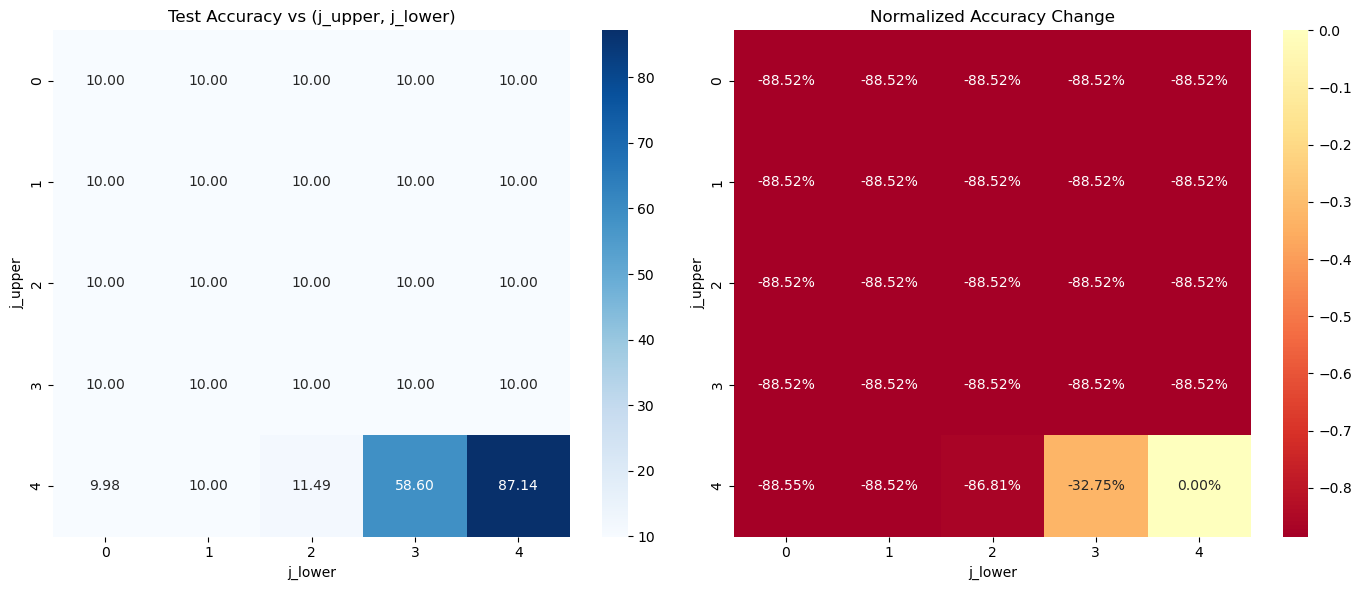


--- Summary for regular ---
 jU  jL    Changed   %Changed   Accuracy
--------------------------------------------------
  0   0 10,863,042     97.22%     10.00%
  0   1 10,630,283     95.13%     10.00%
  0   2 10,168,369     91.00%     10.00%
  0   3  9,248,557     82.77%     10.00%
  0   4  7,412,996     66.34%     10.00%
  1   0 10,863,042     97.22%     10.00%
  1   1 10,630,278     95.13%     10.00%
  1   2 10,168,352     91.00%     10.00%
  1   3  9,248,519     82.77%     10.00%
  1   4  7,412,899     66.34%     10.00%
  2   0 10,860,990     97.20%     10.00%
  2   1 10,624,392     95.08%     10.00%
  2   2 10,153,938     90.87%     10.00%
  2   3  9,216,667     82.48%     10.00%
  2   4  7,346,318     65.74%     10.00%
  3   0 10,784,557     96.52%     10.00%
  3   1 10,443,742     93.46%     10.00%
  3   2  9,754,606     87.30%     10.00%
  3   3  8,375,342     74.95%     10.00%
  3   4  5,618,016     50.28%     10.00%
  4   0 10,466,587     93.67%      9.98%
  4   1  9,772,642

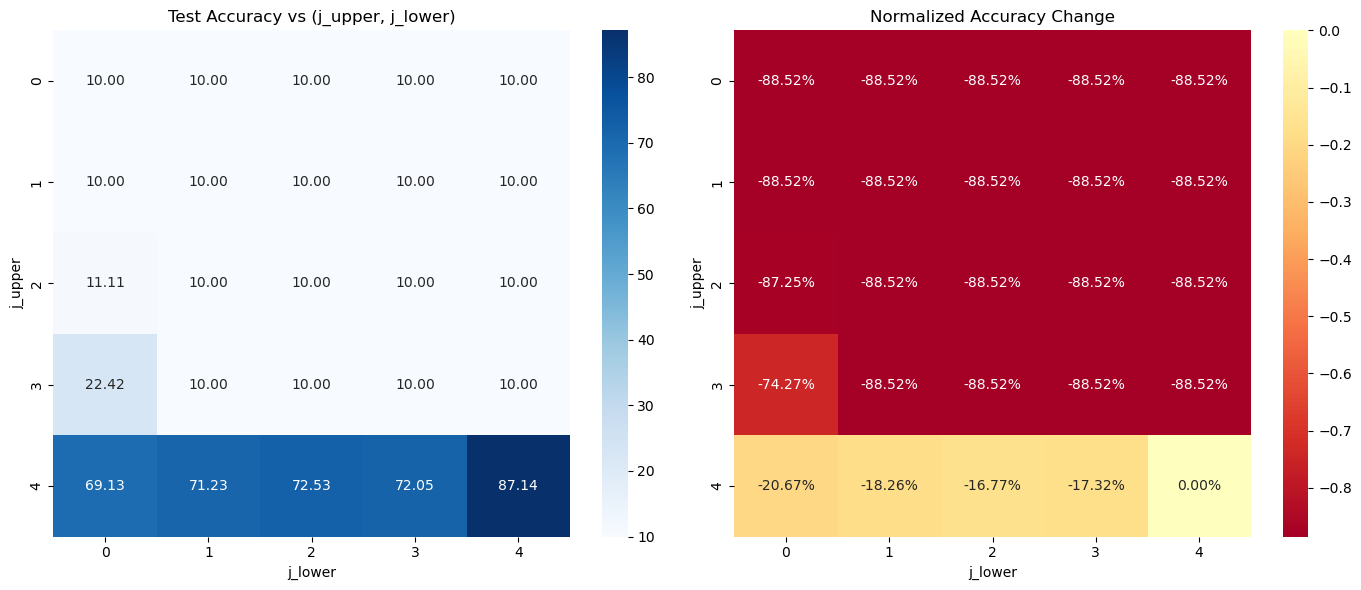


--- Summary for median ---
 jU  jL    Changed   %Changed   Accuracy
--------------------------------------------------
  0   0 11,173,962    100.00%     10.00%
  0   1 11,173,957    100.00%     10.00%
  0   2 11,173,945    100.00%     10.00%
  0   3 11,173,924    100.00%     10.00%
  0   4 11,173,865    100.00%     10.00%
  1   0 11,171,910     99.98%     10.00%
  1   1 11,168,076     99.95%     10.00%
  1   2 11,159,548     99.87%     10.00%
  1   3 11,142,110     99.71%     10.00%
  1   4 11,107,381     99.40%     10.00%
  2   0 11,097,529     99.32%     11.11%
  2   1 10,993,312     98.38%     10.00%
  2   2 10,774,630     96.43%     10.00%
  2   3 10,332,637     92.47%     10.00%
  2   4  9,445,660     84.53%     10.00%
  3   0 10,855,992     97.15%     22.42%
  3   1 10,502,862     93.99%     10.00%
  3   2  9,796,548     87.67%     10.00%
  3   3  8,383,227     75.02%     10.00%
  3   4  5,555,946     49.72%     10.00%
  4   0 10,480,017     93.79%     69.13%
  4   1  9,778,512 

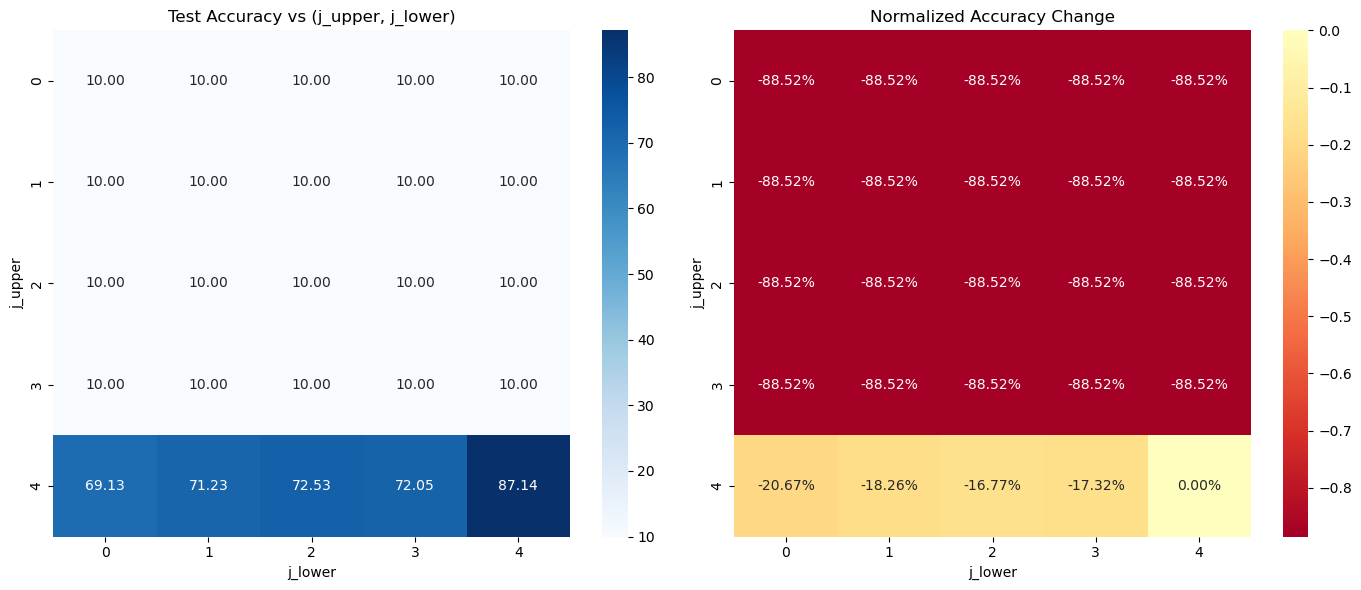


--- Summary for double_median ---
 jU  jL    Changed   %Changed   Accuracy
--------------------------------------------------
  0   0 11,173,957    100.00%     10.00%
  0   1 11,173,950    100.00%     10.00%
  0   2 11,173,941    100.00%     10.00%
  0   3 11,173,903    100.00%     10.00%
  0   4 11,173,865    100.00%     10.00%
  1   0 11,170,128     99.97%     10.00%
  1   1 11,165,434     99.92%     10.00%
  1   2 11,156,524     99.84%     10.00%
  1   3 11,139,233     99.69%     10.00%
  1   4 11,107,381     99.40%     10.00%
  2   0 11,069,745     99.07%     10.00%
  2   1 10,955,280     98.04%     10.00%
  2   2 10,731,969     96.04%     10.00%
  2   3 10,286,985     92.06%     10.00%
  2   4  9,445,660     84.53%     10.00%
  3   0 10,820,832     96.84%     10.00%
  3   1 10,467,648     93.68%     10.00%
  3   2  9,760,641     87.35%     10.00%
  3   3  8,346,681     74.70%     10.00%
  3   4  5,555,946     49.72%     10.00%
  4   0 10,480,017     93.79%     69.13%
  4   1  9,7

In [80]:
import os
import csv

def run_msb_sweep(label, quantized_model, test_loader, quant_params, msb_function, total_params):
    print(f"\n[4-{label}] Sweeping MSB Levels using '{label}' strategy...")
    results = sweep_half_msb_levels(quantized_model, test_loader, quant_params, msb_function)

    print(f"\n--- Summary for {label} ---")
    print(f"{'jU':>3} {'jL':>3} {'Changed':>10} {'%Changed':>10} {'Accuracy':>10}")
    print("-" * 50)
    for r in results:
        pct = (r["num_changed"] / total_params) * 100
        print(f"{r['j_upper']:>3} {r['j_lower']:>3} {r['num_changed']:>10,d} {pct:>9.2f}% {r['accuracy']:>9.2f}%")

    csv_path = f"CIFAR_results/half_msb_results_{label}.csv"
    os.makedirs("CIFAR_results", exist_ok=True)
    with open(csv_path, 'w', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=results[0].keys())
        writer.writeheader()
        writer.writerows(results)
    print(f"Results saved to: {csv_path}")

    hist_dir = f"CIFAR_results/weight_histograms_half_{label}"
    plot_half_weight_histograms(
        quantized_model,
        quant_params,
        msb_function=msb_function,
        output_dir=hist_dir,
        int8_mode=True
    )

# -----------------------------------------
# Main driver
# -----------------------------------------
def main():
    print("=" * 60)
    print("MSB Sensitivity Sweep on Quantized Model (Half-Byte Version)")
    print("=" * 60)

    print("\n[1] Initializing Original Model...")
    total_params = count_total_parameters(original_model)

    print("\n[2] Quantizing Model Weights to 8-bit...")
    os.makedirs("ResNet18_results", exist_ok=True)
    quantized_model, quant_params = quantize_model_weights(original_model)

    print("\n[3] Testing Quantized Model Without Perturbation")
    original_acc, _ = test_model(quantized_model, test_loader, model_name="Quantized No Perturbation")
    print(f"Original Quantized Accuracy: {original_acc:.2f}%")

    msb_functions = {
        "regular": make_halfbyte_msb_function("regular"),
        "median": make_halfbyte_msb_function("median"),
        "double_median": make_halfbyte_msb_function("double_median")

    }

    for label, msb_function in msb_functions.items():
        run_msb_sweep(
            label=label,
            quantized_model=quantized_model,
            test_loader=test_loader,
            quant_params=quant_params,
            msb_function=msb_function,
            total_params=total_params
        )

if __name__ == "__main__":
    main()